In [22]:
!mkdir ResNet_experiment

하위 디렉터리 또는 파일 ResNet_experiment이(가) 이미 있습니다.


In [287]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

## Load CIFAR 100

In [288]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


## Model Architecture

In [289]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, 
                     bias=False)

## Basic Block Module

In [350]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        expansion = self.expansion
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## Bottleneck Module

In [351]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        
        expansion = self.expansion
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## ResNet Module

In [308]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Train, Validate, Test and Experiment

In [309]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() 

        # get the inputs
        inputs, labels = data     
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [310]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc
     

In [311]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [312]:
def experiment(partition, args):

    
    net = ResNet(block = args.block, layers = args.layers, num_classes = 100, zero_init_residual=args.zero_init_residual)
              
    
    
    net.cuda()
    print('{} parameters'.format(sum(p.numel() for p in net.parameters() if p.requires_grad)))
    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2, momentum = 0.9)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

## Manage Experiment Result

In [313]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd


def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']
    del setting['block']
    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './ResNet_experiment/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './ResNet_experiment'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df

## Visualization

In [340]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    df[var2] = df[var2].astype(str)
    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.tight_layout()
   


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.tight_layout()
    

## Experiment 1

In [315]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_optim_lr"

# ====== Regularization ======= #
args.block = Bottleneck
args.layers = [2,2,2,2]
args.zero_init_residual = True

# ====== Regularization ======= #
args.l2 = 0.000001

# ====== Optimizer & Training ====== #
args.optim = 'Adam'
#args.lr = 0.00015
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'optim'
name_var2 = 'lr'
list_var1 = ['RMSprop', 'Adam']
list_var2 = [0.005, 0.0005]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_optim_lr', block=<class '__main__.Bottleneck'>, layers=[2, 2, 2, 2], zero_init_residual=True, l2=1e-05, optim='RMSprop', lr=0.005, epoch=10, train_batch_size=512, test_batch_size=1024)
14151076 parameters
Epoch 0, Acc(train/val): 2.83/2.61, Loss(train/val) 6.01/4.58. Took 14.37 sec
Epoch 1, Acc(train/val): 7.65/7.52, Loss(train/val) 4.04/4.31. Took 14.00 sec
Epoch 2, Acc(train/val): 12.10/2.67, Loss(train/val) 3.73/6.22. Took 13.98 sec
Epoch 3, Acc(train/val): 15.22/7.19, Loss(train/val) 3.52/4.67. Took 13.90 sec
Epoch 4, Acc(train/val): 19.71/8.34, Loss(train/val) 3.29/4.58. Took 14.08 sec
Epoch 5, Acc(train/val): 22.61/9.72, Loss(train/val) 3.12/4.39. Took 14.26 sec
Epoch 6, Acc(train/val): 25.74/16.07, Loss(train/val) 2.96/3.64. Took 14.16 sec
Epoch 7, Acc(train/val): 29.25/10.24, Loss(train/val) 2.78/4.86. Took 14.18 sec
Epoch 8, Acc(train/val): 32.32/14.97, Loss(train/val) 2.62/4.08. Took 14.03 sec
Epoch 9, Acc(train/val): 36.63/16.01, Loss(train/val) 2.42

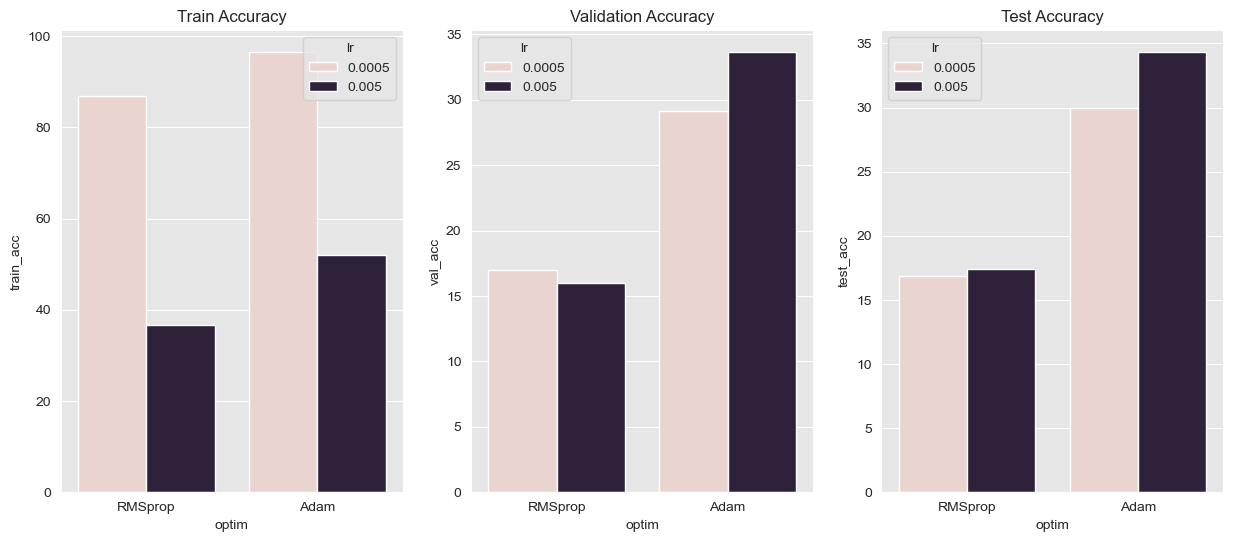

In [330]:
df = load_exp_result("exp1_optim_lr")
var1 = 'optim'
var2 = 'lr'
plot_acc(var1, var2, df)

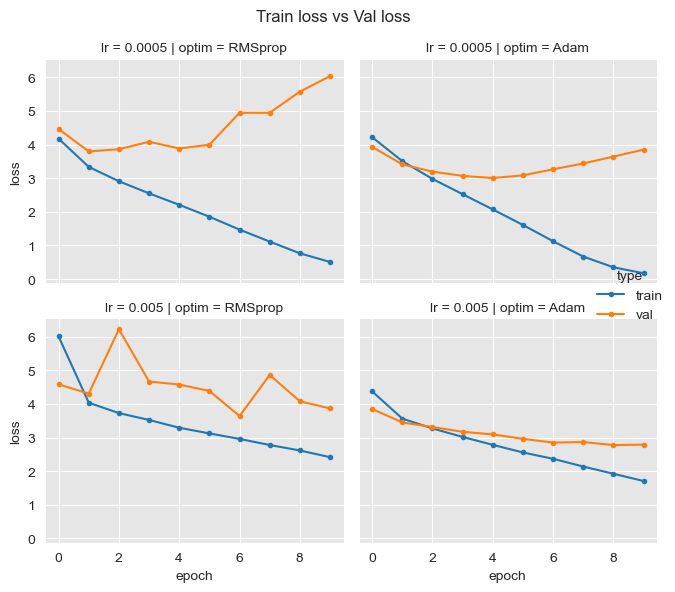

In [332]:
plot_loss_variation(var1, var2, df)

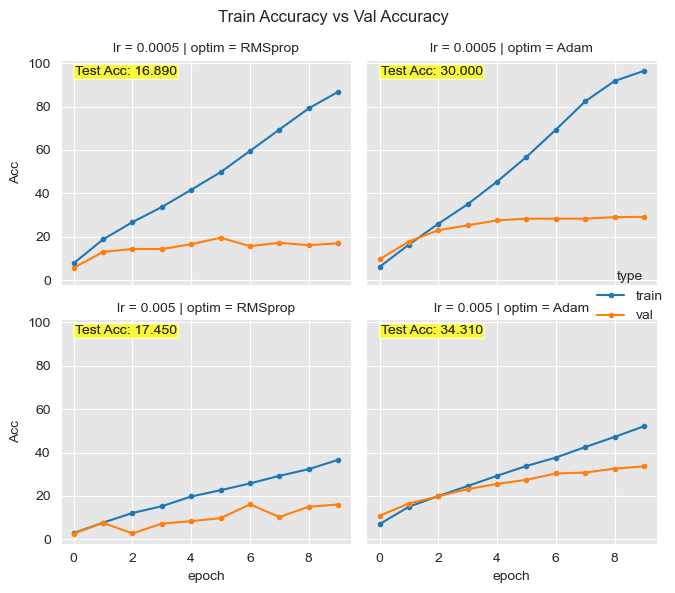

In [333]:
plot_acc_variation(var1, var2, df)

## Experiment 2

In [324]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_#_of_layer_train_batch_size"

# ====== Regularization ======= #
args.block = Bottleneck
#args.layers = [1,1,1,1]
args.zero_init_residual = True

# ====== Regularization ======= #
args.l2 = 0.000001

# ====== Optimizer & Training ====== #
args.optim = 'Adam'
args.lr = 0.0015
args.epoch = 20

#args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'train_batch_size'
name_var2 = 'layers'
list_var1 = [128, 256, 512]
list_var2 = [[1,1,1,1], [2,2,2,2]]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp2_#_of_layer_train_batch_size', block=<class '__main__.Bottleneck'>, zero_init_residual=True, l2=1e-06, optim='Adam', lr=0.0015, epoch=20, test_batch_size=1024, train_batch_size=128, layers=[1, 1, 1, 1])
8220836 parameters
Epoch 0, Acc(train/val): 9.91/15.94, Loss(train/val) 3.99/3.50. Took 14.16 sec
Epoch 1, Acc(train/val): 20.61/22.11, Loss(train/val) 3.26/3.14. Took 13.55 sec
Epoch 2, Acc(train/val): 27.87/28.30, Loss(train/val) 2.87/2.87. Took 13.69 sec
Epoch 3, Acc(train/val): 33.43/29.98, Loss(train/val) 2.58/2.80. Took 13.49 sec
Epoch 4, Acc(train/val): 39.62/32.57, Loss(train/val) 2.28/2.67. Took 13.60 sec
Epoch 5, Acc(train/val): 45.56/35.57, Loss(train/val) 2.01/2.56. Took 13.97 sec
Epoch 6, Acc(train/val): 51.97/37.02, Loss(train/val) 1.73/2.57. Took 13.56 sec
Epoch 7, Acc(train/val): 58.65/36.68, Loss(train/val) 1.44/2.66. Took 13.75 sec
Epoch 8, Acc(train/val): 66.63/36.43, Loss(train/val) 1.13/2.79. Took 13.65 sec
Epoch 9, Acc(train/val): 74.62/37.2

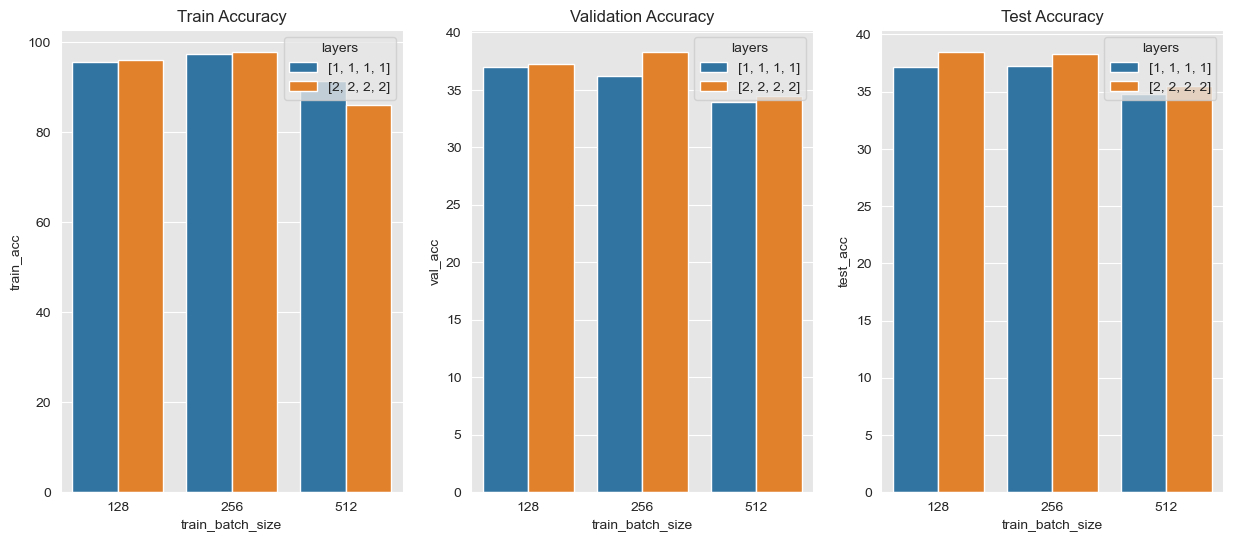

In [343]:
df = load_exp_result("exp2")
var1 = 'train_batch_size'
var2 = 'layers'
plot_acc(var1, var2, df)

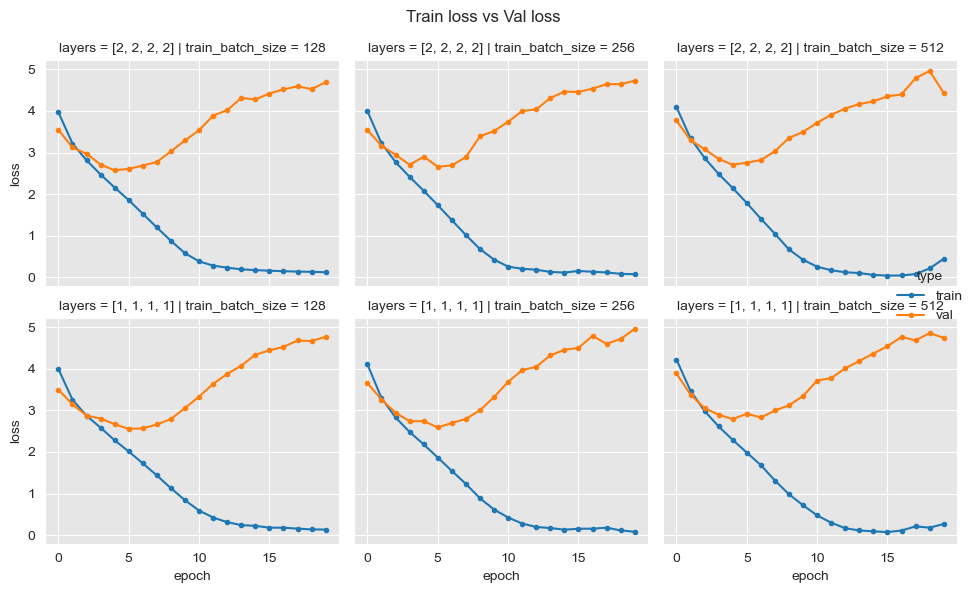

In [344]:
plot_loss_variation(var1, var2, df)

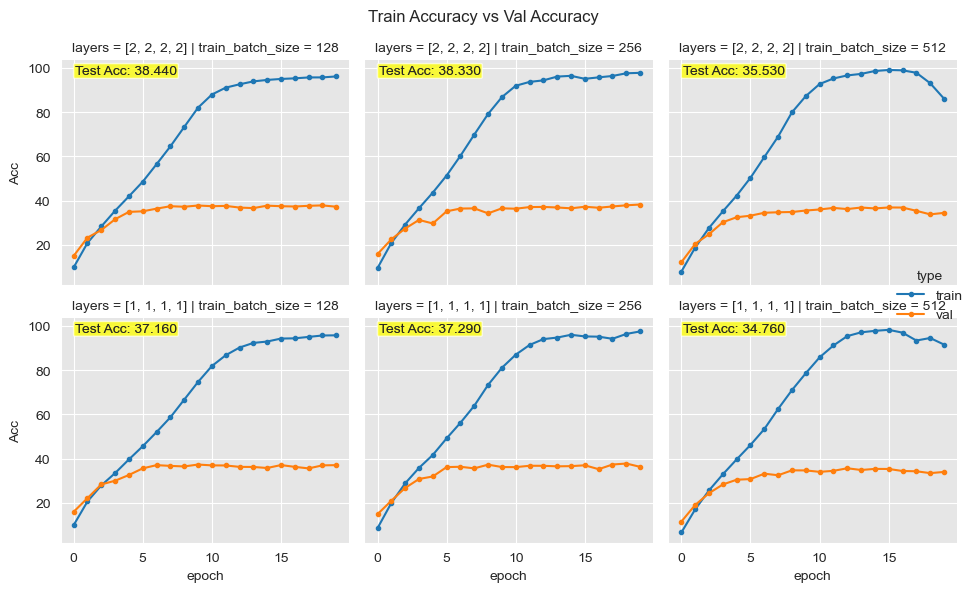

In [345]:
plot_acc_variation(var1, var2, df)

## Experiment3

In [352]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_optim_lr"

# ====== Regularization ======= #
args.block = Bottleneck
args.layers = [1,1,1,1]
args.zero_init_residual = True

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
#args.optim = 'SGD'
#args.lr = 0.0005
args.epoch = 15

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'optim'
name_var2 = 'lr'
list_var1 = ['SGD', 'Adam']
list_var2 = [0.005, 0.0005, 0.00005, 0.0015, 0.00015]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp3_optim_lr', block=<class '__main__.Bottleneck'>, layers=[1, 1, 1, 1], zero_init_residual=True, l2=1e-05, epoch=15, train_batch_size=256, test_batch_size=1024, optim='SGD', lr=0.005)
8220836 parameters
Epoch 0, Acc(train/val): 2.90/3.68, Loss(train/val) 4.50/4.40. Took 12.78 sec
Epoch 1, Acc(train/val): 4.58/4.62, Loss(train/val) 4.34/4.31. Took 12.71 sec
Epoch 2, Acc(train/val): 5.19/5.13, Loss(train/val) 4.27/4.28. Took 12.58 sec
Epoch 3, Acc(train/val): 5.83/5.82, Loss(train/val) 4.22/4.25. Took 12.62 sec
Epoch 4, Acc(train/val): 6.31/5.76, Loss(train/val) 4.19/4.23. Took 12.65 sec
Epoch 5, Acc(train/val): 6.72/5.72, Loss(train/val) 4.17/4.22. Took 12.52 sec
Epoch 6, Acc(train/val): 6.95/6.37, Loss(train/val) 4.15/4.20. Took 12.62 sec
Epoch 7, Acc(train/val): 7.34/5.82, Loss(train/val) 4.13/4.23. Took 12.57 sec
Epoch 8, Acc(train/val): 7.42/6.11, Loss(train/val) 4.11/4.20. Took 12.63 sec
Epoch 9, Acc(train/val): 7.64/6.42, Loss(train/val) 4.09/4.19. Took 12.57

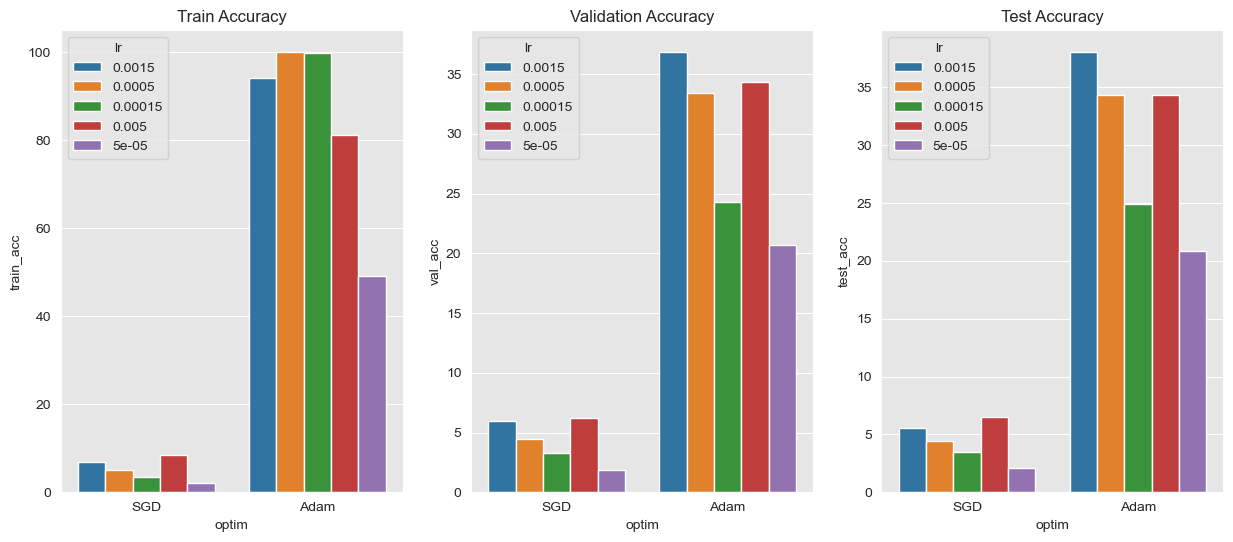

In [353]:
df = load_exp_result("exp3")
var1 = 'optim'
var2 = 'lr'
plot_acc(var1, var2, df)

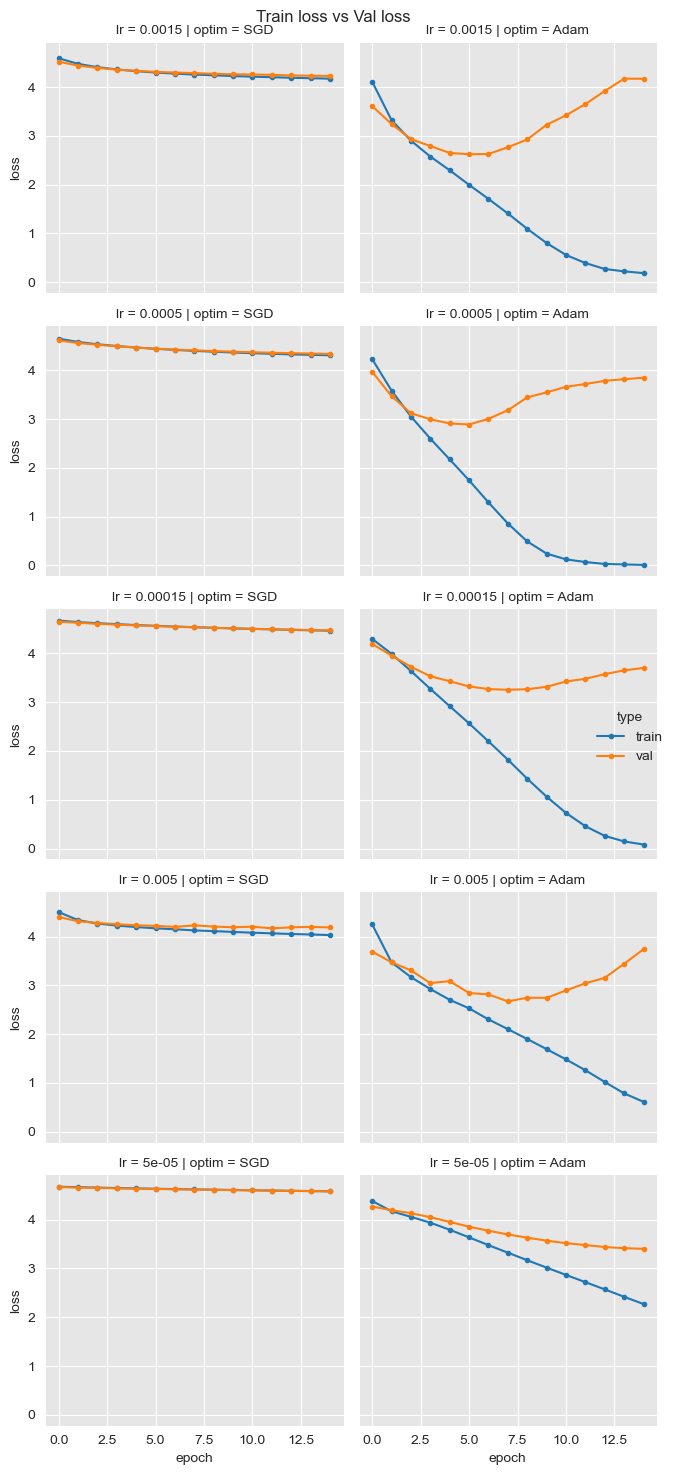

In [354]:
plot_loss_variation(var1, var2, df)

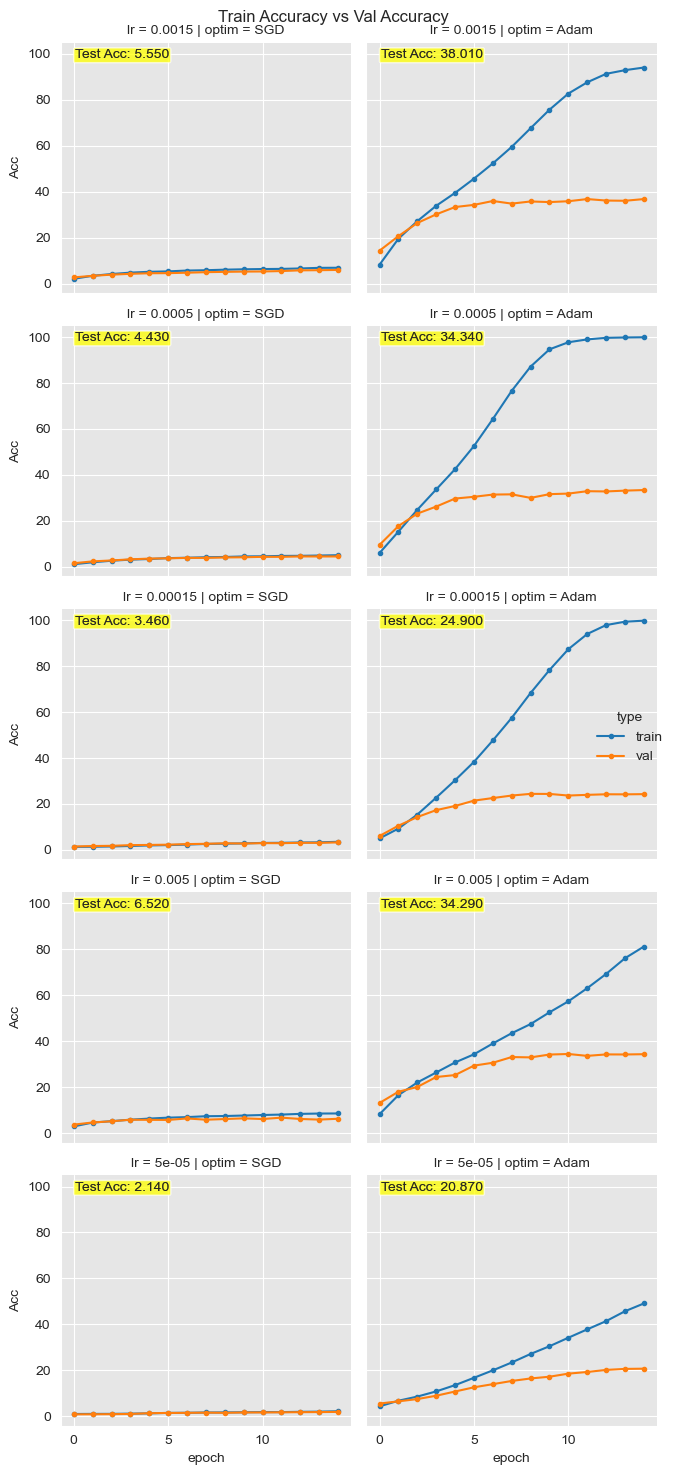

In [355]:
plot_acc_variation(var1, var2, df)

## Experiment 4

In [357]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4_layer_lr"

# ====== Regularization ======= #
args.block = Bottleneck
args.zero_init_residual = True

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'Adam'
#args.lr = 0.0005
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'layers'
list_var1 = [0.005,0.0005, 0.00015]
list_var2 = [[2,2,2,2], [3,4,6,3]]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp4_layer_lr', block=<class '__main__.Bottleneck'>, zero_init_residual=True, l2=1e-05, optim='Adam', epoch=10, train_batch_size=256, test_batch_size=1024, lr=0.005, layers=[2, 2, 2, 2])
14151076 parameters
Epoch 0, Acc(train/val): 8.18/11.75, Loss(train/val) 4.18/3.79. Took 14.52 sec
Epoch 1, Acc(train/val): 16.62/17.16, Loss(train/val) 3.45/3.47. Took 14.32 sec
Epoch 2, Acc(train/val): 22.04/22.11, Loss(train/val) 3.17/3.21. Took 14.39 sec
Epoch 3, Acc(train/val): 26.17/26.07, Loss(train/val) 2.93/2.97. Took 14.24 sec
Epoch 4, Acc(train/val): 30.66/27.87, Loss(train/val) 2.70/2.92. Took 14.43 sec
Epoch 5, Acc(train/val): 35.26/29.01, Loss(train/val) 2.48/2.86. Took 14.17 sec
Epoch 6, Acc(train/val): 39.00/28.33, Loss(train/val) 2.29/3.02. Took 14.13 sec
Epoch 7, Acc(train/val): 43.34/32.90, Loss(train/val) 2.08/2.69. Took 14.27 sec
Epoch 8, Acc(train/val): 48.19/33.68, Loss(train/val) 1.86/2.73. Took 14.40 sec
Epoch 9, Acc(train/val): 53.33/33.85, Loss(train/val) 

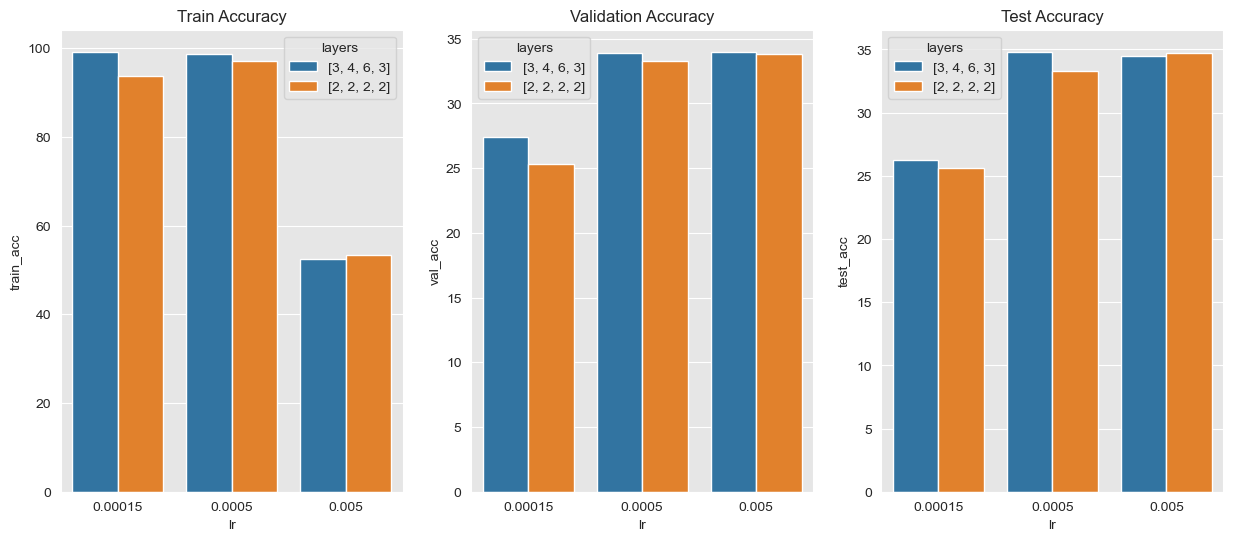

In [358]:
df = load_exp_result("exp4")
var1 = 'lr'
var2 = 'layers'
plot_acc(var1, var2, df)

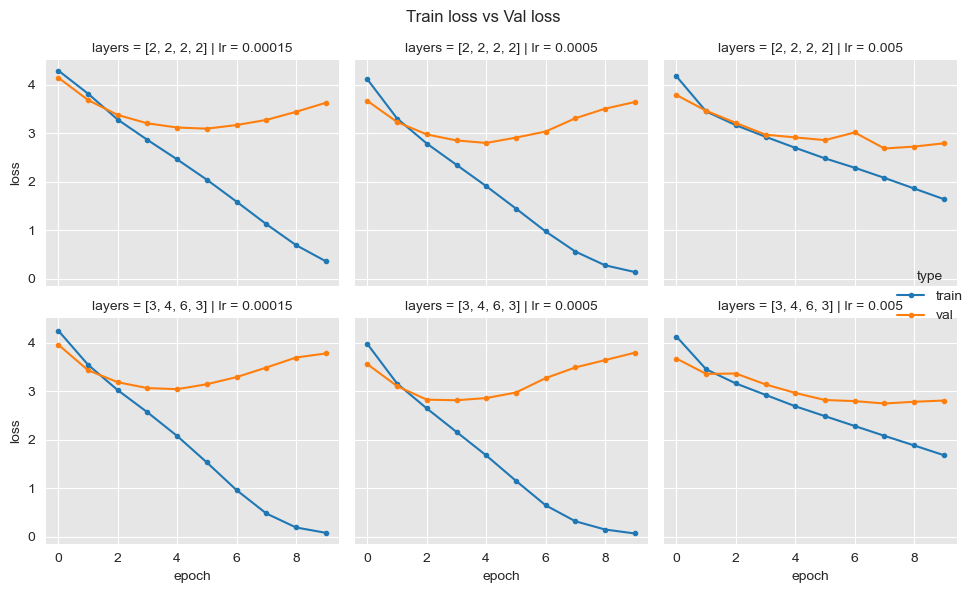

In [359]:
plot_loss_variation(var1, var2, df)

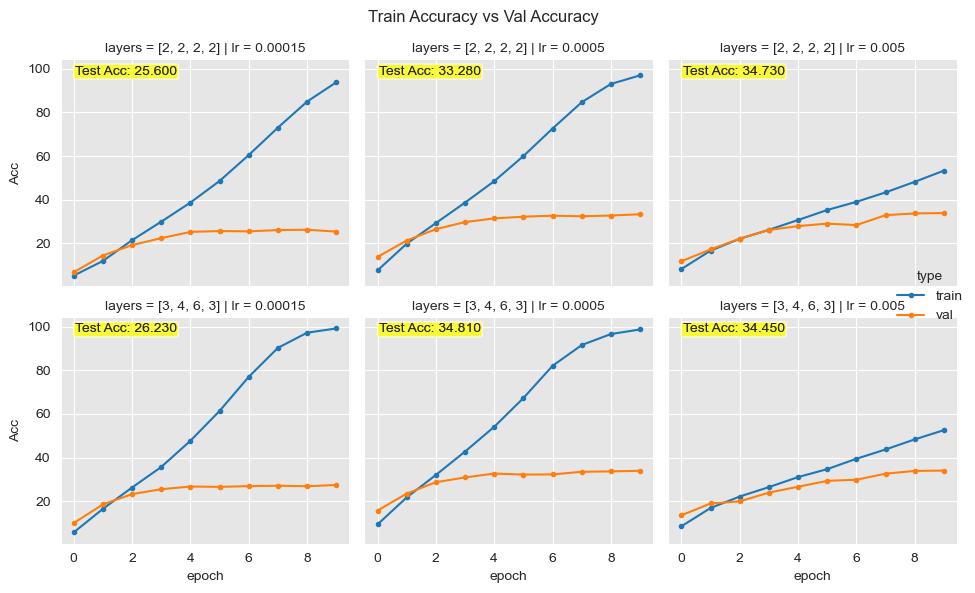

In [360]:
plot_acc_variation(var1, var2, df)